## Instalação e importação das bibliotecas

In [1]:
!pip install plotly==5.3.1
!pip install pmdarima
!pip install -U kaleido

import numpy as np
import pandas as pd
import plotly as pl
import plotly.graph_objects as go
import plotly.io as pio
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
import plotly.express as px 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from statsmodels.tsa.api import ExponentialSmoothing

pio.renderers.default = "png"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 23.9 MB 4.8 MB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 5.5.0
    Uninstalling plotly-5.5.0:
      Successfully uninstalled plotly-5.5.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 2.0 MB/s 
     |████████████████████████████████| 9.8 MB 48.9 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79.9 MB 1.3 MB/s 


## Importação dos dados

In [2]:
df = pd.read_csv('daily-min-temperatures.csv', parse_dates=['Date'], index_col='Date')
df = df.asfreq('D')

## Análise inicial

In [3]:
# Cabeçalho
df.head(10)

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8
1981-01-06,15.8
1981-01-07,15.8
1981-01-08,17.4
1981-01-09,21.8


In [4]:
# Rodapé
df.tail(10)

,Temp
Date,
1990-12-22,13.2
1990-12-23,13.9
1990-12-24,10.0
1990-12-25,12.9
1990-12-26,14.6
1990-12-27,14.0
1990-12-28,13.6
1990-12-29,13.5
1990-12-30,15.7


In [5]:
# Número de linhas e colunas
df.shape

(3652, 1)

In [6]:
# Tipo dos dados
df.dtypes

Temp    float64
dtype: object

In [7]:
# Dados faltantes
df.isnull().sum()

Temp    2
dtype: int64

In [8]:
# Estatística descritiva
df.describe()

,Temp
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


In [9]:
# Busca dos valores faltantes
df[df.Temp.isnull()]

,Temp
Date,
1984-12-31,NaN
1988-12-31,NaN


In [10]:
# Imputação dos valores faltantes
df.loc['1984-12-31'] = df.loc['1984-12-30']
df.loc['1988-12-31'] = df.loc['1988-12-30']

In [11]:
# Dados faltantes
df.isnull().sum()

Temp    0
dtype: int64

## Visualização

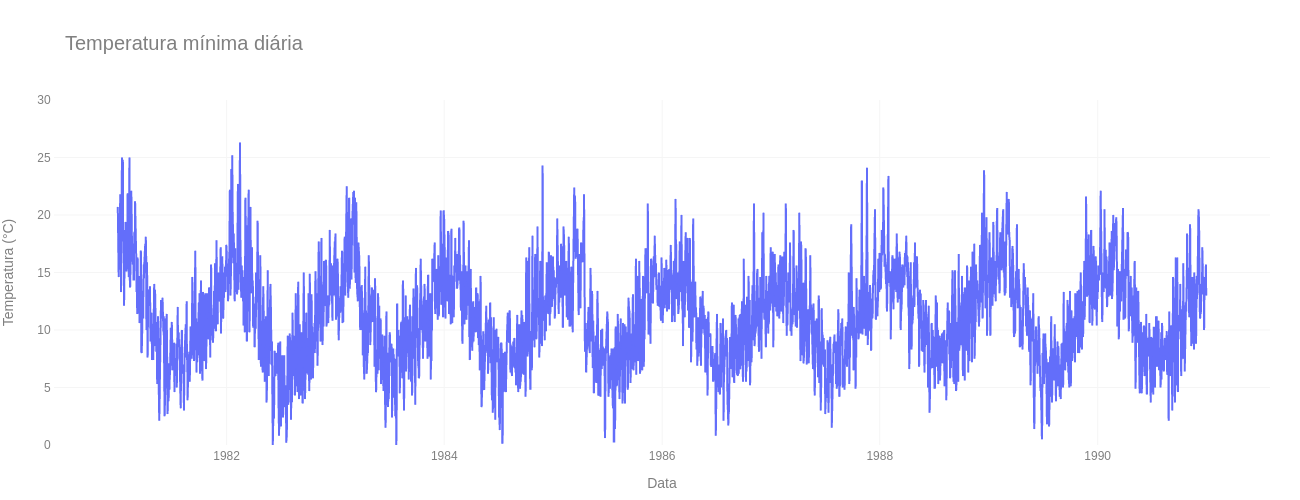

In [12]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        y            = df['Temp'],
        x            = df.index,
        mode         = 'lines+markers',
        marker       = {'size': .5},
    )
)

fig.update_layout(
    title            = 'Temperatura mínima diária</i></sup>',
    title_font_color = 'gray',
    title_font_size  = 20,
    width            = 1300,
    height           = 500,
    margin           = {'l': 30, 'r': 30, 't': 100, 'b': 30},
    plot_bgcolor     = 'white',
    font_color       = 'gray',
    xaxis1           = {
        'showline': True,
        'title': 'Data',
        'showticklabels': True,
        'gridcolor': 'whitesmoke'
    },
    yaxis1           = {
        'showline': True,
        'title': 'Temperatura (°C)',
        'showticklabels': True,
        'range': [0, 30],
        'gridcolor': 'whitesmoke'
    }
)

fig.show()

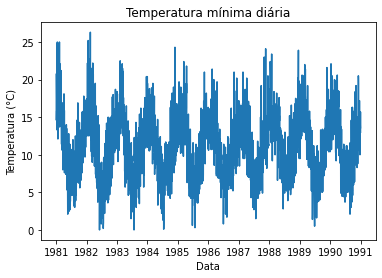

In [13]:
plt.plot(df.index, 'Temp', data=df)
plt.title('Temperatura mínima diária')
plt.xlabel('Data')
plt.ylabel('Temperatura (°C)')
plt.show()

## Decomposição da série temporal

In [14]:
decomposicao = seasonal_decompose(df, model='additive', period=365)
tendencia = decomposicao.trend
sazonalidade = decomposicao.seasonal
residual = decomposicao.resid

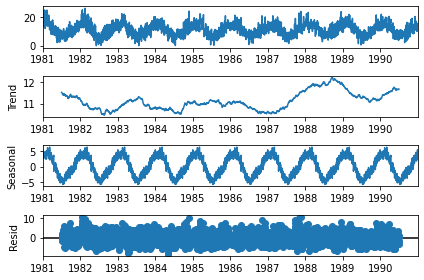

In [15]:
decomposicao.plot()
plt.show()

Como observado pela decomposição da série temporal, não há uma tendência clara nos dados, porém é nítida uma sazonalidade (de tempo anual).

## Estacionariedade

In [16]:
teste = adfuller(df['Temp'])

In [17]:
teste

(-4.440933664385131,
 0.0002510472415292774,
 20,
 3631,
 {'1%': -3.4321522387754775,
  '5%': -2.862336328589075,
  '10%': -2.567193897993964},
 16651.240027625234)

In [18]:
print('Valor-p: %f' %teste[1])

Valor-p: 0.000251


Pelo teste de Dickey-Fuller, considerando uma significância de 5%, rejeita-se a hipótese nula de que se trata de uma série não-estacionária, já que o p-valor foi menor que 0,05. Portanto, o teste valida positivamente a estacionariedade da série temporal.

## Média móvel

In [19]:
df['media_movel'] = df['Temp'].rolling(window = 60).mean()

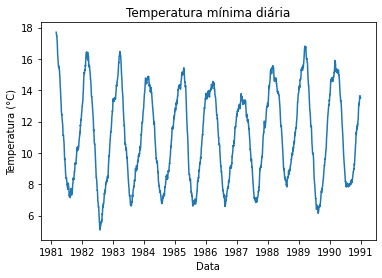

In [20]:
plt.plot(df.index, 'media_movel', data=df)
plt.title('Temperatura mínima diária')
plt.xlabel('Data')
plt.ylabel('Temperatura (°C)')
plt.show()

Pela análise da média móvel, utilizando uma janela de dois meses (60 períodos), é possível notar que o comportamento da temperatura mínima diária varia razoavelmente em torno de uma média constante e possui forte componente de sazonalidade anual.

## Previsão utilizando modelo ARIMA

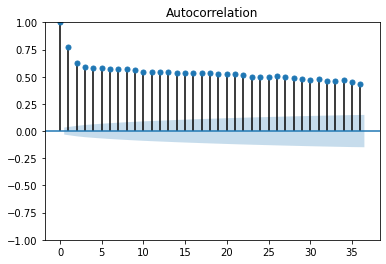

In [21]:
plot_acf(df['Temp'])
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



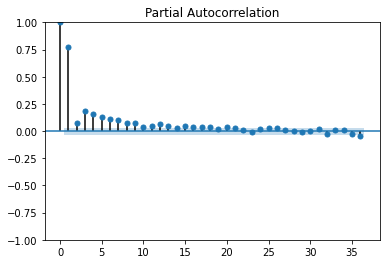

In [22]:
plot_pacf(df['Temp'])
plt.show()

In [23]:
modelo = ARIMA(df['Temp'], order=(7,0,5))
modelo_fit = modelo.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



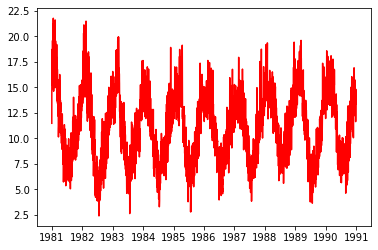

In [24]:
plt.plot(modelo_fit.fittedvalues, color='red')

In [25]:
print(modelo_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   Temp   No. Observations:                 3652
Model:                 ARIMA(7, 0, 5)   Log Likelihood               -8386.232
Date:                Sat, 08 Oct 2022   AIC                          16800.464
Time:                        18:13:49   BIC                          16887.307
Sample:                    01-01-1981   HQIC                         16831.390
                         - 12-31-1990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.4708      0.821     13.975      0.000       9.862      13.080
ar.L1         -0.3915      1.209     -0.324      0.746      -2.761       1.978
ar.L2          0.2180      1.129      0.193      0.8

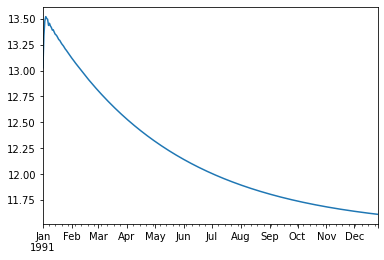

In [26]:
# Previsão de 12 meses
previsao = modelo_fit.get_forecast(steps=30*12, alpha=0.1).predicted_mean
previsao.plot()

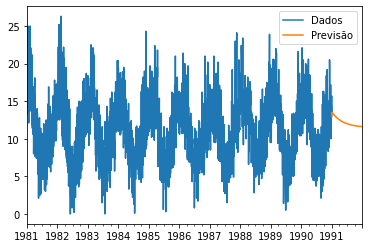

In [27]:
df_ext = pd.concat([df['Temp'], previsao], axis=1)
df_ext.columns = ['Dados', 'Previsão']
df_ext.plot()

In [28]:
#modelo_auto = auto_arima(df['Temp'], start_p=1, start_q=1, m=365, seasonal=True, d=1, stepwise=True)
# Muito demorado. Rodou por mais de uma hora e não foi concluído

## Previsão utilizando modelo de Suavização Exponencial

In [29]:
modelo2 = ExponentialSmoothing(df['Temp'], seasonal_periods=365, trend='additive', seasonal='additive').fit()

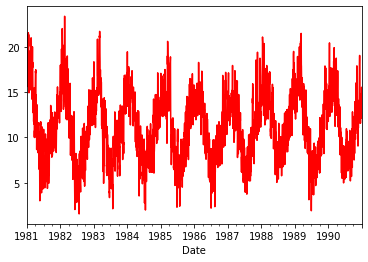

In [30]:
modelo2.fittedvalues.plot(color='red')

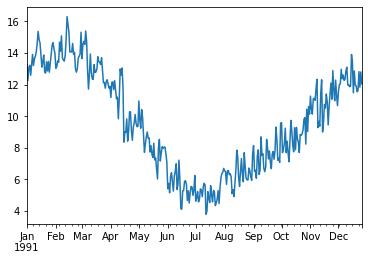

In [31]:
# Previsão de 12 meses
previsao2 = modelo2.forecast(30*12)
previsao2.plot()

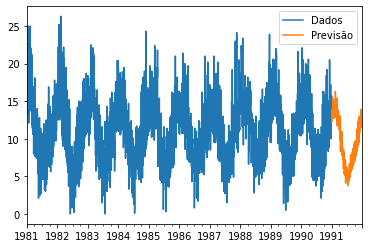

In [32]:
df_ext2 = pd.concat([df['Temp'], previsao2], axis=1)
df_ext2.columns = ['Dados', 'Previsão']
df_ext2.plot()